In [110]:
import pandas as pd
import numpy as np
from datetime import date
from dateutil import relativedelta as rd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from helpers import utils

In [111]:
def mean_absolute_percentage_error(y_true, y_pred): 
#     mask = y_true <> 0
#     return (np.fabs(y_true - y_pred) / y_true)[mask].mean()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
def load_data():
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
    df = pd.read_csv(utils.get_external_file('AirPassengers.csv'), parse_dates=['Month'], index_col='Month',date_parser=dateparse)
    df.columns = ['passengers']
    return df

data = load_data()
data.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


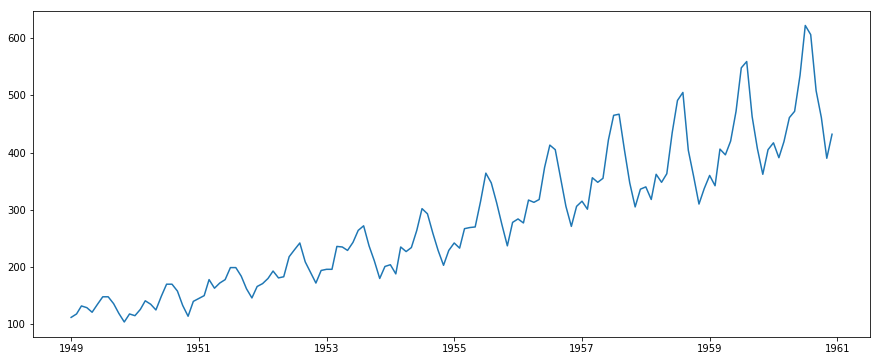

In [13]:
plt.plot(data);

In [47]:
def get_historical_slice(df, forecast_start, horizon=12):
    train = df[:forecast_start - rd.relativedelta(months=1)]
    test = df[forecast_start:forecast_start + rd.relativedelta(months=horizon-1)]
    
    return train, test

train, test = get_historical_slice(data, date(1951, 3, 1))
print('train:', train.index.min(), train.index.max())
print('test:', test.index.min(), test.index.max())

train: 1949-01-01 00:00:00 1951-02-01 00:00:00
test: 1951-03-01 00:00:00 1952-02-01 00:00:00


In [77]:
def naive(train, idx):
    return (
        pd.Series(train.iloc[-1].passengers, index=idx)
    )

naive(train, test.index)

Month
1951-03-01    150
1951-04-01    150
1951-05-01    150
1951-06-01    150
1951-07-01    150
1951-08-01    150
1951-09-01    150
1951-10-01    150
1951-11-01    150
1951-12-01    150
1952-01-01    150
1952-02-01    150
dtype: int64

In [78]:
def seasonal_naive(train, idx):
    return (
        pd.Series(train[-12:].passengers.values, index=idx)
    )

seasonal_naive(train, test.index)

Month
1951-03-01    141
1951-04-01    135
1951-05-01    125
1951-06-01    149
1951-07-01    170
1951-08-01    170
1951-09-01    158
1951-10-01    133
1951-11-01    114
1951-12-01    140
1952-01-01    145
1952-02-01    150
dtype: int64

In [106]:
def moving_average(train, idx, window=12):
    return pd.Series(train.rolling(window=window, center=False).mean().iloc[-12:].passengers.values, index=idx)

moving_average(train, test.index)

Month
1951-03-01    128.333333
1951-04-01    128.833333
1951-05-01    129.166667
1951-06-01    130.333333
1951-07-01    132.166667
1951-08-01    134.000000
1951-09-01    135.833333
1951-10-01    137.000000
1951-11-01    137.833333
1951-12-01    139.666667
1952-01-01    142.166667
1952-02-01    144.166667
dtype: float64

In [112]:
def evaluate_model(model, label):
    plt.plot(train, color='blue', label='historic')
    plt.plot(test, color='blue', label='observed', linestyle='--')
    plt.plot(model, color='orange', label=label)
    plt.legend(loc='best')
    plt.show();

    mse = mean_squared_error(test.passengers, model)
    mae = mean_absolute_error(test.passengers, model)
    mape = mean_absolute_percentage_error(test.passengers, model)
    
    print('Test MSE: %.3f' % mse)
    print('Test MAE: %.3f' % mae)
    print('Test MAPE: %.3f' % mape)

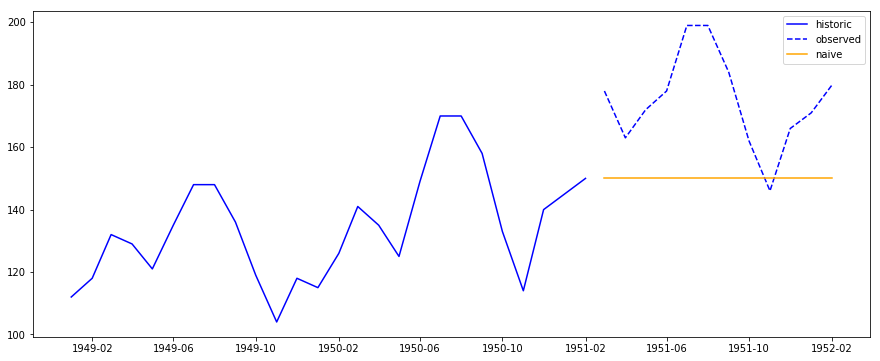

Test MSE: 828.000
Test MAE: 25.500
Test MAPE: 14.057


In [113]:
evaluate_model(naive(train, test.index), 'naive')

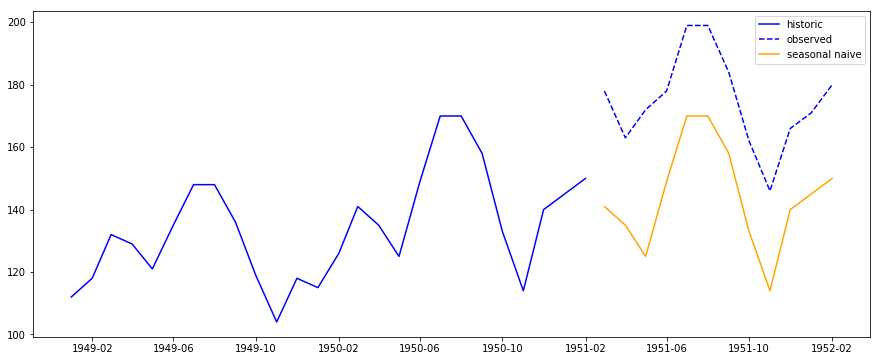

Test MSE: 973.167
Test MAE: 30.667
Test MAPE: 17.684


In [114]:
evaluate_model(seasonal_naive(train, test.index), 'seasonal naive')

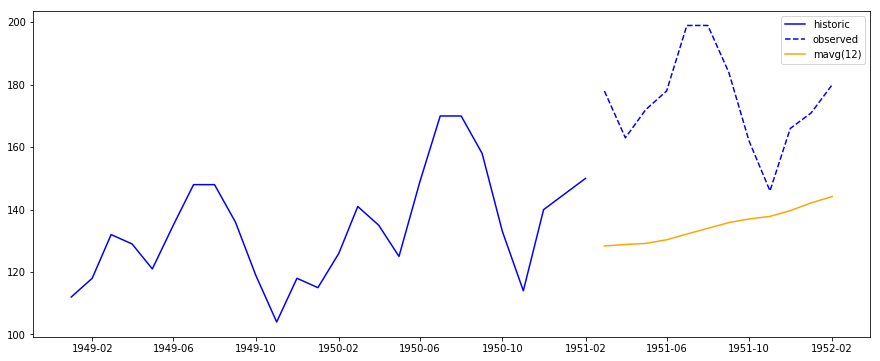

Test MSE: 1854.433
Test MAE: 39.875
Test MAPE: 22.219


In [115]:
evaluate_model(moving_average(train, test.index), 'mavg(12)')

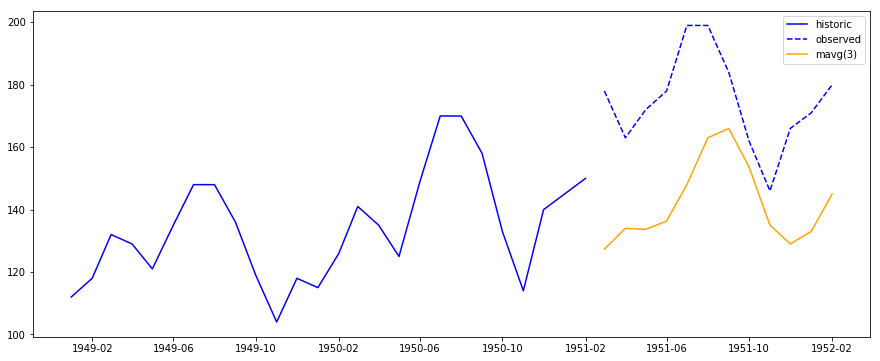

Test MSE: 1255.259
Test MAE: 32.833
Test MAPE: 18.507


In [116]:
evaluate_model(moving_average(train, test.index, 3), 'mavg(3)')